# Задача о многоруком бандите

## Постановка задачи

Пусть у нас есть автомат - “многорукий бандит”, то есть машина с `n` ручками. На каждом шаге игры мы можем дернуть одну из ручек, и получить за это случайную награду. Распределения вероятностей случайных величин наград на каждой ручке разные, и мы их не знаем. Задача - найти стратегию игры, при которой мы сможем получить максимальную награду за фиксированное количество шагов игры.

## Где задачу можно использовать:

- Персонализация показов рекламы в Интернете (где бандит - пользователь, ручки - разные рекламные баннеры, которые мы можем ему показывать, а награда - его клики по баннерам);
- Управление ценами и ассортиментом в магазинах (бандит - покупатель, ручки - разные товары / цены на товар, награда - прибыль, которые покупатель нам приносит);
- Игра на бирже (бандит - биржа, ручки - разные ценные бумаги, продаваемые там, а награда - прибыль, которую приносит покупка выбранной ценной бумаги в перспективе);
- и так далее

## Формализуем задачу:

- `A`<sub>t</sub> - множество возможных действий агента (т.е. Ручки бандита)
- `p`<sub>a</sub>`(r)` - неизвестное распределение премии `r` из `R` для каждого `a` из `A` (в модели будем полагать, что все эти распределения - нормальны с дисперсией 1, а средние для них будем генерить исходя из нормального распределения с заданными на этапе инициализации бандита параметрами `mu` и `sigma`).
- `Pi`<sub>t</sub>`(a)` - стратегия агента в момент `t`, являющаяся распределением на `A` (то есть `Pi`<sub>t</sub>`(a)` - вероятность того, что агент в момент времени `t` выберет действие `a`)


- `Q`<sub>t</sub>`(a)` - средняя награда за выбор действия `a` среди `t` пройденных шагов
- `A`<sub>t</sub> `= argmax Q`<sub>t</sub>`(a)` по `a` из `A` - множество действий с максимальной средней наградой (по данным, накопленным нами за `t` шагов игры)

**Замечание**: По факту, абсолютные значения средних у ручек не влияют на процесс обучения. Влияет лишь модуль разности между этими средними.

**Замечание**: Дисперсии наград на ручках влияние оказывают: чем они больше, тем дольше придется обучаться (так как чем больше дисперсия, тем больше вероятность на начальных этапах принять хорошую ручку за плохую, и наоборот).

В этой задаче встает классическая проблема “изучения-применения” (“exploration-exploitation”), когда нам приходится на каждом шаге выбирать между стратегией “изучения” (выбираем случайное действие, дабы набирать статистику по всем действиям, и хорошо угадать среднюю награду на каждой ручке), и стратегией “применения” (выбирать действие, которое, по данным на нынешний момент игры, принесет максимальную награду).

### Инициализация для моделирования

In [1]:
import bandit as bd

n_arms = 10           # Количество ручек бандита
n_trials = 1000       # Количество шагов игры в эксперименте
n_experiments = 500   # Количество экспериментов
mu = 2                # Среднее, вокруг которого случайно выбираются средние значения наград ручек

bandit = bd.Bandit(n_arms, mu)

## Алгоритмы решения:

### Исследовательская (случайная) стратегия

На каждом шаге выбираем случайное действие равномерно вне зависимости от награды.

Недостаток - как мы вообще не двигаемся в сторону максимизации награды, а значит это самое медленное решение из всех.

**Замечание**: можно комбинировать решения, использую исследовательскую стратегию на начальном этапе для обучения, а дальше играть по жадной (в предположении отсутствия динамики в распределениях ручек).

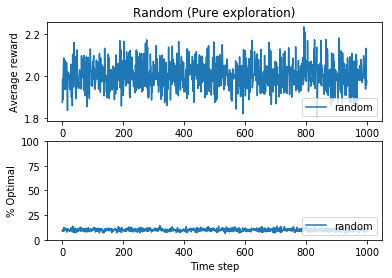

In [2]:
rnd_agents = [
    bd.Agent(bandit, bd.RandomPolicy())
]
rnd_env = bd.Environment(bandit, rnd_agents, label='Random (Pure exploration)')
rnd_scores, rnd_optimal = rnd_env.run(n_trials, n_experiments)
rnd_env.plot(rnd_scores, rnd_optimal)

### Жадная стратегия

На каждом шаге мы выбираем действие, которое, как нам кажется, принесет максимальную прибыль (то есть полностью вкладываемся в стратегию “применения”). 

<img src="files/images/greedy.png" style="height: 75px;">

Недостаток - мы можем так и не набрать статистику по некоторым ручкам, что может привести к ложному решению о оптимальной ручке.

### E-жадная стратегия

Представляет собой статичный компромисс между “изучением” и “применением”. На каждом шаге с вероятностью `E` идем в сторону “изучения”, выбирая случайное действие, а с вероятностью `1-E` - идем в сторону “применения”, играя по жадной стратегии.

<img src="files/images/e-greedy.png" style="height: 75px;">

Здесь нужно подбирать E под конкретную задачу. А еще, `E` стоит уменьшать со временем.

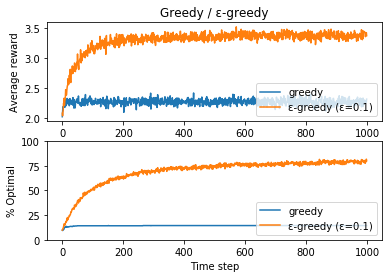

In [3]:
agents = [
    bd.Agent(bandit, bd.GreedyPolicy()),           # Выбираем epsilon = 0.1, как лучшее значение параметра,
    bd.Agent(bandit, bd.EpsilonGreedyPolicy(0.1))  # полученное эскпериментальным методом
]
env = bd.Environment(bandit, agents, label='Greedy / \u03B5-greedy')
scores, optimal = env.run(n_trials, n_experiments)
env.plot(scores, optimal)

### Стратегия Softmax

Мягкий компромисс между “изучением” и “применением”.
Выбираем параметр `T`, и дальше выбираем действие по формуле:

<img src="files/images/softmax.png" style="height: 100px;">

Параметр `T` сглаживает стратегию выбора относительно жадной:
- `T -> 0` – стратегия стремится к жадной (просто выбираем действие с максимальным `Q`<sub>t</sub>`(a)`)
- `T -> ∞` – стратегия стремится к чисто исследовательской (выбираем действия случайно)

Здесь `T` тоже нужно подбирать под конкретную задачу (экспериментально), и тоже уменьшать со временем.

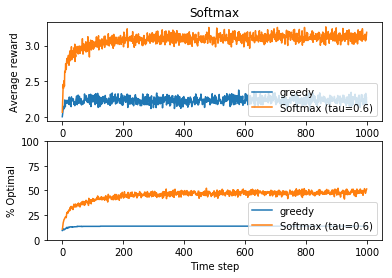

In [4]:
sm_agents = [
    bd.Agent(bandit, bd.GreedyPolicy()),      # Выбираем tau = 0.6, как лучшее значение параметра,
    bd.Agent(bandit, bd.SoftmaxPolicy(0.6))   # полученное эскпериментальным методом
]
sm_env = bd.Environment(bandit, sm_agents, label='Softmax')
sm_scores, sm_optimal = sm_env.run(n_trials, n_experiments)
sm_env.plot(sm_scores, sm_optimal)

### Сравнение

Будем сравнивать E-жадную стратегию и Softmax (так как они обе сильно лучше, чем жадная, и с ней нет смысла сравнивать).

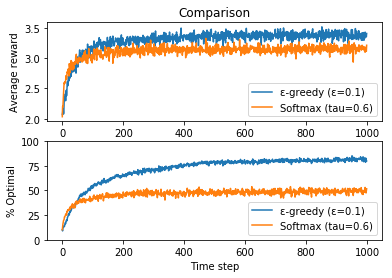

In [5]:
all_agents = [
    bd.Agent(bandit, bd.EpsilonGreedyPolicy(0.1)),
    bd.Agent(bandit, bd.SoftmaxPolicy(0.6))
]
all_env = bd.Environment(bandit, all_agents, label='Comparison')
all_scores, all_optimal = all_env.run(n_trials, n_experiments)
all_env.plot(all_scores, all_optimal)

### Вывод

В рамках смоделированного случая получилось, что агент, обучающийся с помощью `E`-жадной стратегии с `E = 0.1`, обучился быстрее и лучше, чем агент, использующий стратегию Softmax.

## Резкие изменения в распределениях наград

Смоделируем поведение наших алгоритмов обучения в случае, если после продолжительного периода времени распределения в наградах резко изменяются (к примеру, во время показа рекламы в интернете, интересы клиентов резко изменились из-за сезонности, или какого-нибудь другого фактора).

### Жадная и E-жадная стратегии

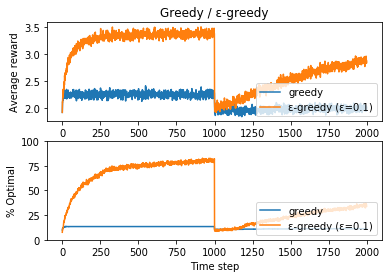

In [6]:
scores_with_change, optimal_with_change = env.run_with_change(n_trials, n_trials, n_experiments)
env.plot(scores_with_change, optimal_with_change)

### Стратегия Softmax

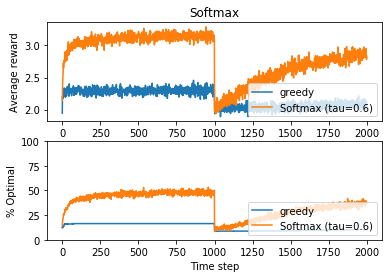

In [7]:
sm_scores_with_change, sm_optimal_with_change = sm_env.run_with_change(n_trials, n_trials, n_experiments)
sm_env.plot(sm_scores_with_change, sm_optimal_with_change)

### Сравнение E-жадной и Softmax

Дадим обеим стратегиям больше времени на перестройку, чтобы посмотреть, насколько медленно они обучаются заново.

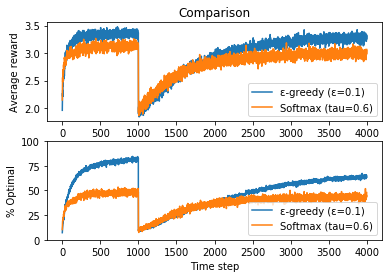

In [8]:
all_scores_with_change, all_optimal_with_change = all_env.run_with_change(n_trials, n_trials * 3, n_experiments)
all_env.plot(all_scores_with_change, all_optimal_with_change)

### Вывод

При резкой смене распределений наград на ручках, оба алгоритма (E-жадный и Softmax) перестраиваются примерно одинаково (несмотря на то, что в момент смены E-жадный работал лучше). И тому, и другому нужно очень много времени на то, чтобы перестроиться под новые распределений на ручках (как видно из эксперимента, даже за время, в 3 раза большее времени изначального обучения, ни один из алгоритмов не смог обучиться под новые распределения так же хорошо, как научился на первом этапе).